<a href="https://colab.research.google.com/github/andreas31603/MachineLearningTasks/blob/main/Task12/CNNCifar10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [23]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
from torch.optim.lr_scheduler import ReduceLROnPlateau
import matplotlib.pyplot as plt
import numpy as np

In [24]:
# Memeriksa apakah CUDA tersedia dan memilih device (GPU/CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [25]:
# Persiapan Data
# Transformasi data: konversi ke tensor dan normalisasi
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Memuat dataset CIFAR-10
dataset = datasets.CIFAR10(root="./data", train=True, download=True, transform=transform)

# Hanya gunakan subset dari dataset asli (10,000 data)
subset_size = 10000
dataset = torch.utils.data.Subset(dataset, range(subset_size))

# Pisahkan dataset menjadi data pelatihan dan validasi
train_size = 8000
val_size = 2000
train_data, val_data = random_split(dataset, [train_size, val_size])

# DataLoader untuk pelatihan dan validasi
train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
val_loader = DataLoader(val_data, batch_size=64, shuffle=False)


Files already downloaded and verified


In [26]:
# Arsitektur CNN
class CNN(nn.Module):
    def __init__(self, kernel_size):
        super(CNN, self).__init__()
        # Layer konvolusi pertama dengan kernel size yang dapat disesuaikan
        self.conv1 = nn.Conv2d(3, 32, kernel_size=kernel_size, padding=kernel_size // 2)
        self.pool1 = nn.MaxPool2d(2, 2)  # Max pooling pertama
        self.conv2 = nn.Conv2d(32, 64, kernel_size=kernel_size, padding=kernel_size // 2)
        self.pool2 = nn.AvgPool2d(2, 2)  # Average pooling kedua
        self.fc1 = nn.Linear(64 * 8 * 8, 256)  # Fully connected layer pertama
        self.fc2 = nn.Linear(256, 10)  # Fully connected layer kedua

    def forward(self, x):
        # Forward pass data melalui setiap layer
        x = self.pool1(torch.relu(self.conv1(x)))
        x = self.pool2(torch.relu(self.conv2(x)))
        x = x.view(-1, 64 * 8 * 8)  # Flatten output untuk FC layer
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [28]:
# Fungsi Pelatihan Model
def train_model(model, train_loader, val_loader, optimizer, scheduler, criterion, epochs):
    train_losses, val_losses = [], []
    early_stop_counter = 0
    best_val_loss = float('inf')

    for epoch in range(epochs):
        model.train()  # Set model ke mode pelatihan
        train_loss = 0
        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)  # Pindahkan data ke device
            optimizer.zero_grad()  # Reset gradien
            outputs = model(inputs)  # Forward pass
            loss = criterion(outputs, targets)  # Hitung loss
            loss.backward()  # Backward pass
            optimizer.step()  # Update parameter
            train_loss += loss.item()

        train_loss /= len(train_loader)
        train_losses.append(train_loss)

        model.eval()  # Set model ke mode evaluasi
        val_loss = 0
        with torch.no_grad():  # Nonaktifkan gradien untuk validasi
            for inputs, targets in val_loader:
                inputs, targets = inputs.to(device), targets.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                val_loss += loss.item()

        val_loss /= len(val_loader)
        val_losses.append(val_loss)

        scheduler.step(val_loss)  # Scheduler untuk mengatur learning rate
        print(f"Epoch {epoch+1}/{epochs} - Train Loss: {train_loss:.4f} - Val Loss: {val_loss:.4f}")

        if val_loss < best_val_loss:  # Simpan model terbaik
            best_val_loss = val_loss
            early_stop_counter = 0
        else:
            early_stop_counter += 1

        if early_stop_counter >= 10:  # Hentikan pelatihan jika tidak ada perbaikan
            print("Early stopping triggered")
            break

        # Tampilkan progress secara real-time
        print(f"[Progress] Epoch {epoch+1}/{epochs}: Train Loss={train_loss:.4f}, Val Loss={val_loss:.4f}")

    return train_losses, val_losses

# Main
kernel_sizes = [3, 5, 7]  # Kernel size yang diuji
epochs_list = [5, 50, 100, 200]  # Jumlah epoch yang diuji
optimizers = {'SGD': optim.SGD, 'RMSProp': optim.RMSprop, 'Adam': optim.Adam}

results = {}

for kernel_size in kernel_sizes:
    for epochs in epochs_list:
        for opt_name, opt_func in optimizers.items():
            print(f"Training with Kernel Size {kernel_size}, Epochs {epochs}, Optimizer {opt_name}")

            model = CNN(kernel_size=kernel_size).to(device)  # Inisialisasi model
            criterion = nn.CrossEntropyLoss()  # Loss function
            optimizer = opt_func(model.parameters(), lr=0.001)  # Optimizer
            scheduler = ReduceLROnPlateau(optimizer, 'min', patience=3)  # Learning rate scheduler

            train_losses, val_losses = train_model(
                model, train_loader, val_loader, optimizer, scheduler, criterion, epochs
            )

            results[(kernel_size, epochs, opt_name)] = (train_losses, val_losses)


Training with Kernel Size 3, Epochs 5, Optimizer SGD
Epoch 1/5 - Train Loss: 2.3017 - Val Loss: 2.2989
[Progress] Epoch 1/5: Train Loss=2.3017, Val Loss=2.2989
Epoch 2/5 - Train Loss: 2.2985 - Val Loss: 2.2959
[Progress] Epoch 2/5: Train Loss=2.2985, Val Loss=2.2959
Epoch 3/5 - Train Loss: 2.2953 - Val Loss: 2.2930
[Progress] Epoch 3/5: Train Loss=2.2953, Val Loss=2.2930
Epoch 4/5 - Train Loss: 2.2920 - Val Loss: 2.2899
[Progress] Epoch 4/5: Train Loss=2.2920, Val Loss=2.2899
Epoch 5/5 - Train Loss: 2.2884 - Val Loss: 2.2865
[Progress] Epoch 5/5: Train Loss=2.2884, Val Loss=2.2865
Training with Kernel Size 3, Epochs 5, Optimizer RMSProp
Epoch 1/5 - Train Loss: 1.8870 - Val Loss: 1.5830
[Progress] Epoch 1/5: Train Loss=1.8870, Val Loss=1.5830
Epoch 2/5 - Train Loss: 1.5035 - Val Loss: 1.4115
[Progress] Epoch 2/5: Train Loss=1.5035, Val Loss=1.4115
Epoch 3/5 - Train Loss: 1.3493 - Val Loss: 1.3457
[Progress] Epoch 3/5: Train Loss=1.3493, Val Loss=1.3457
Epoch 4/5 - Train Loss: 1.2221 - V

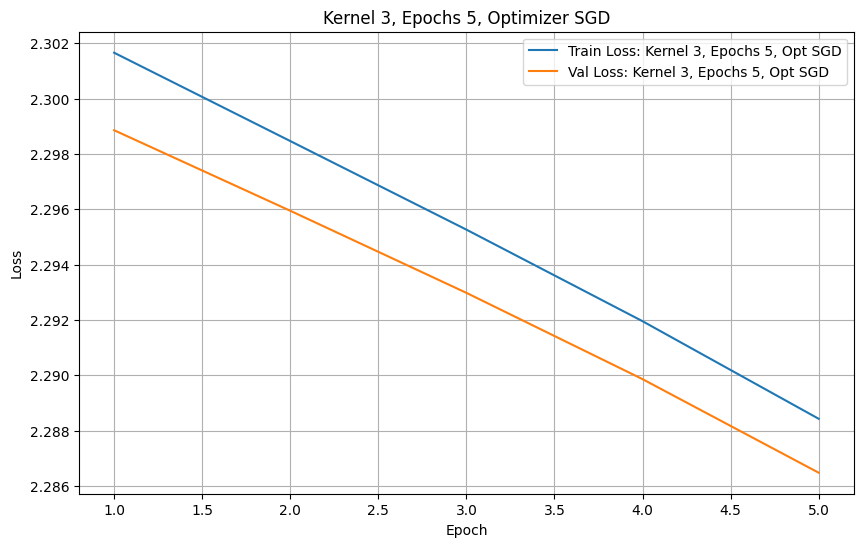

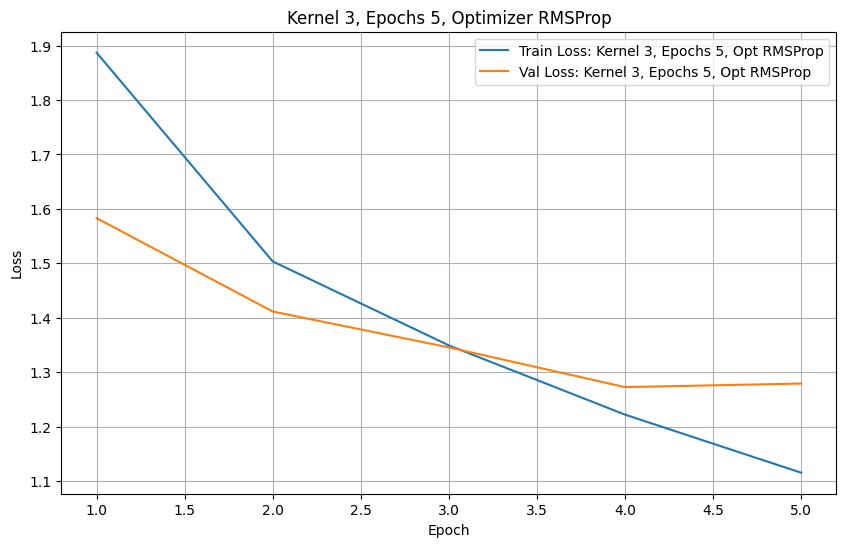

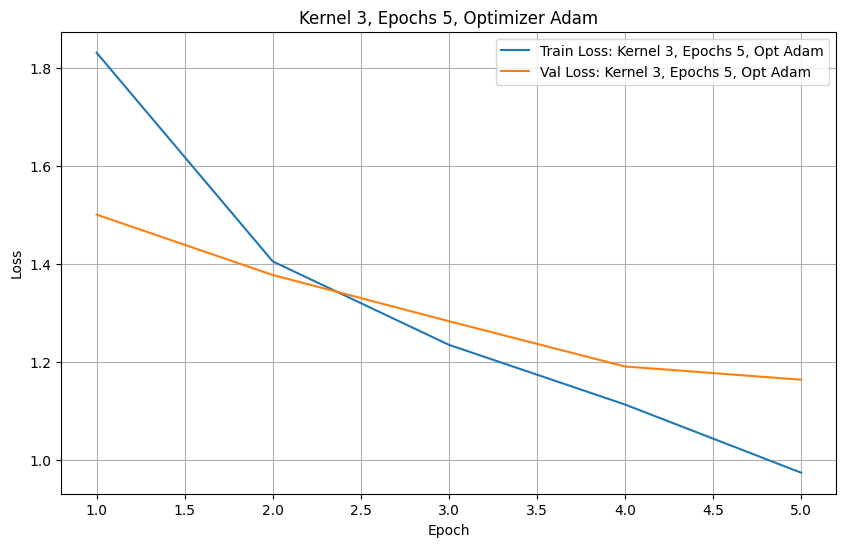

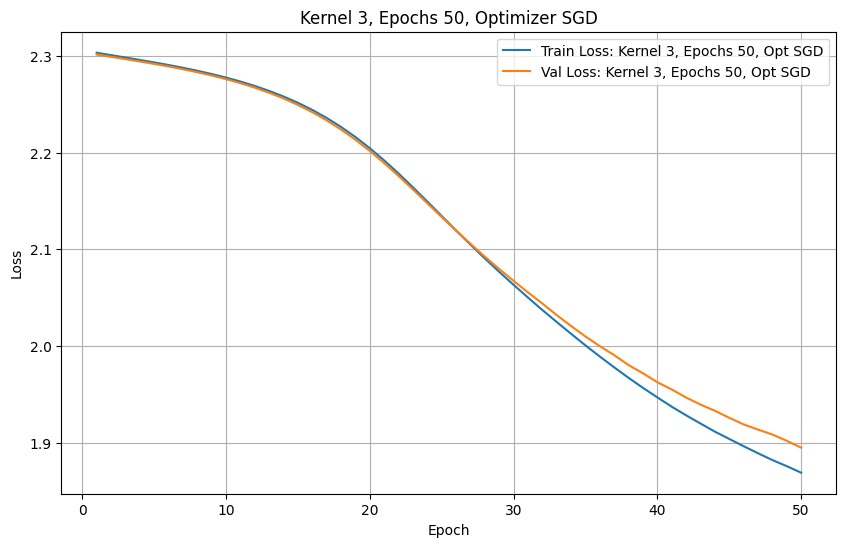

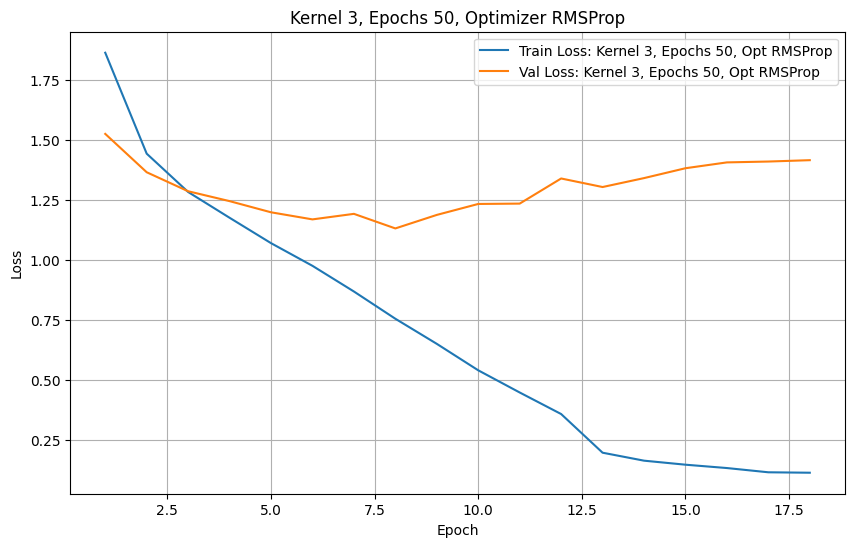

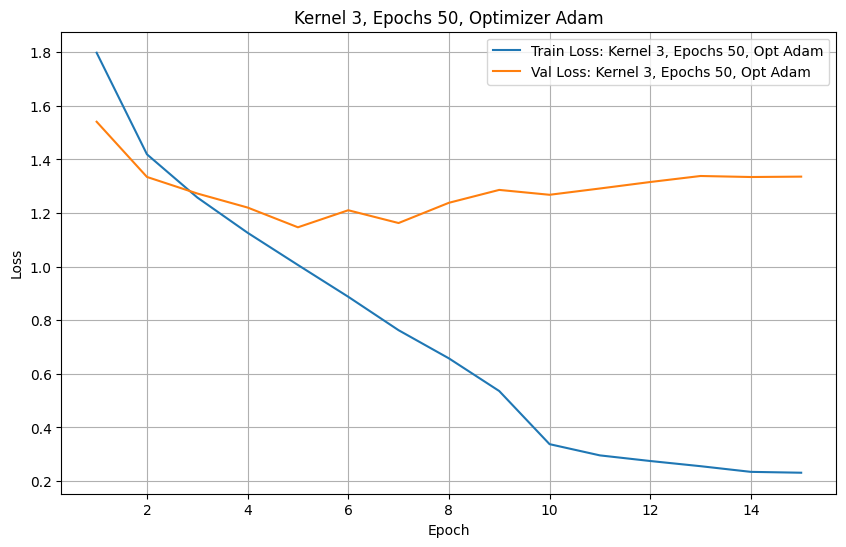

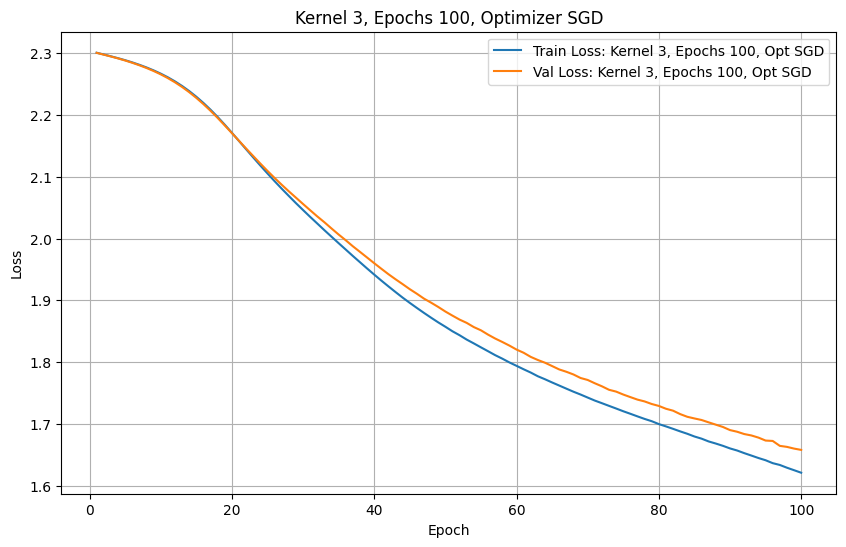

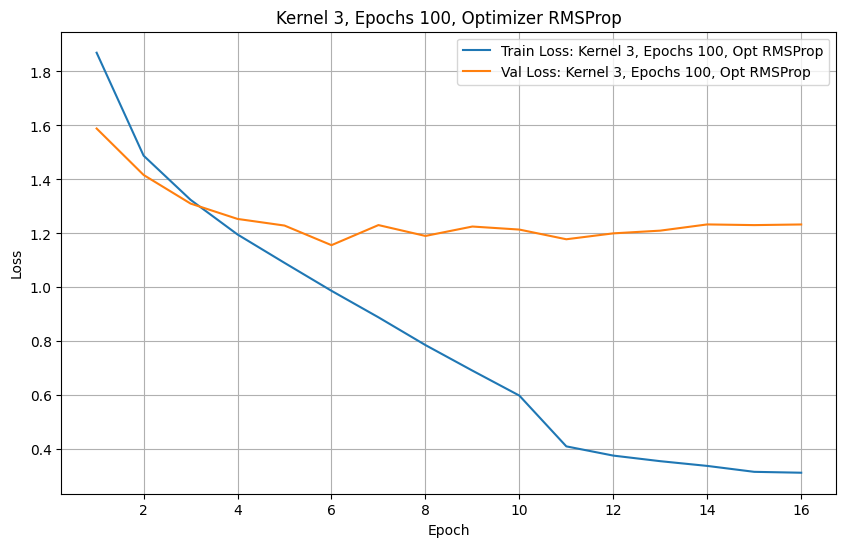

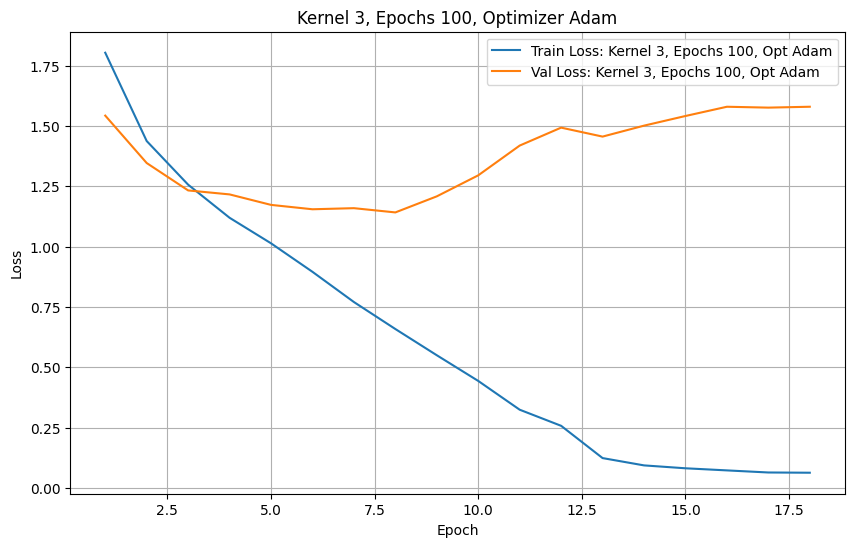

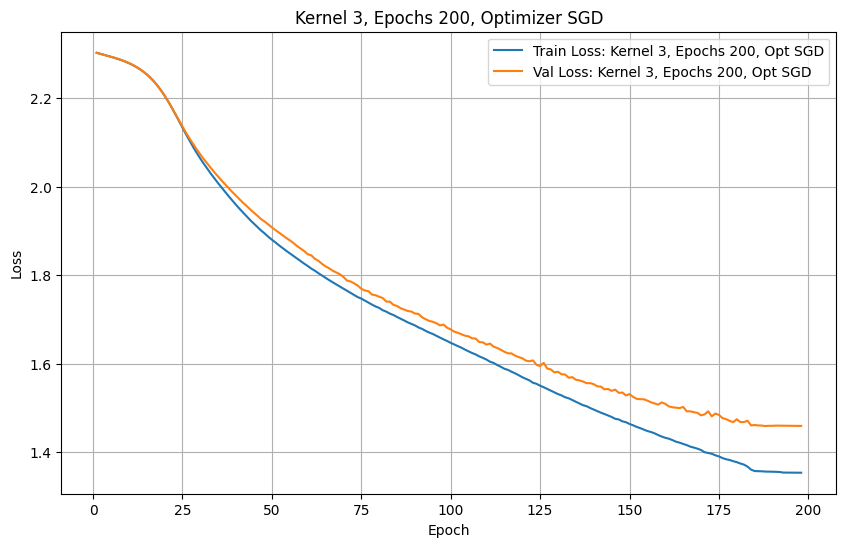

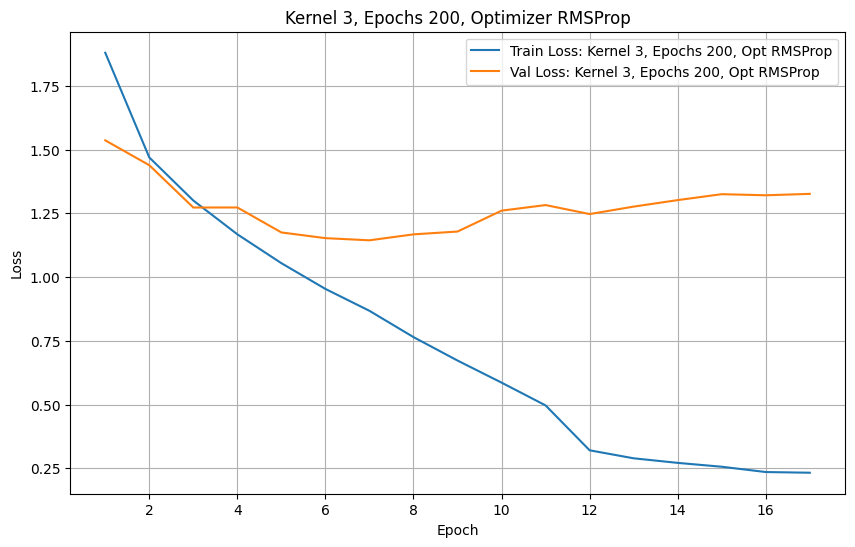

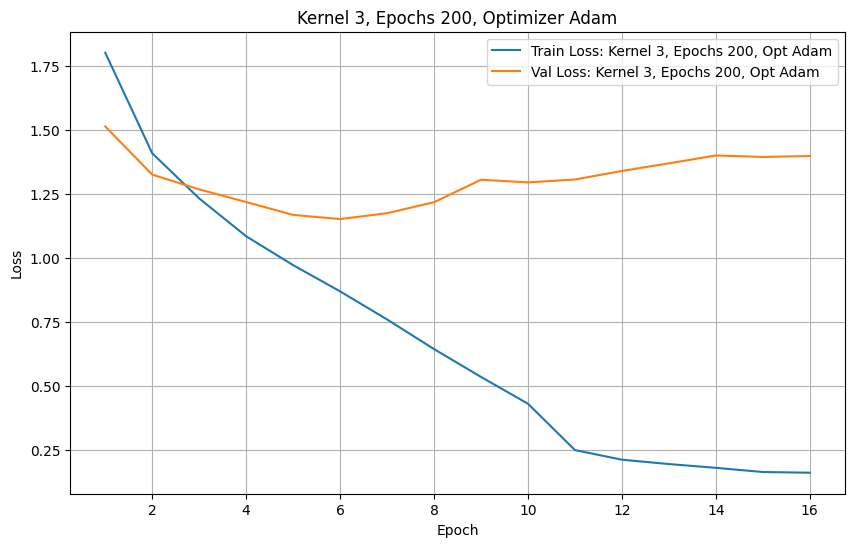

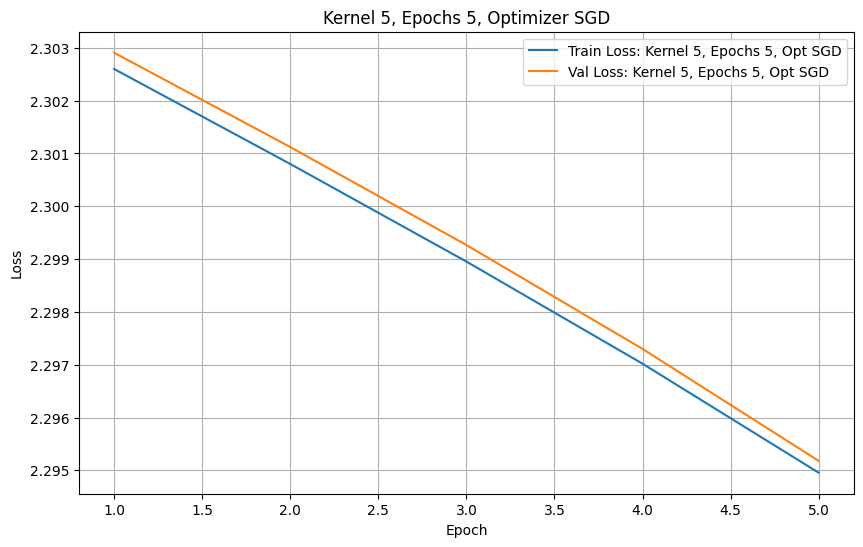

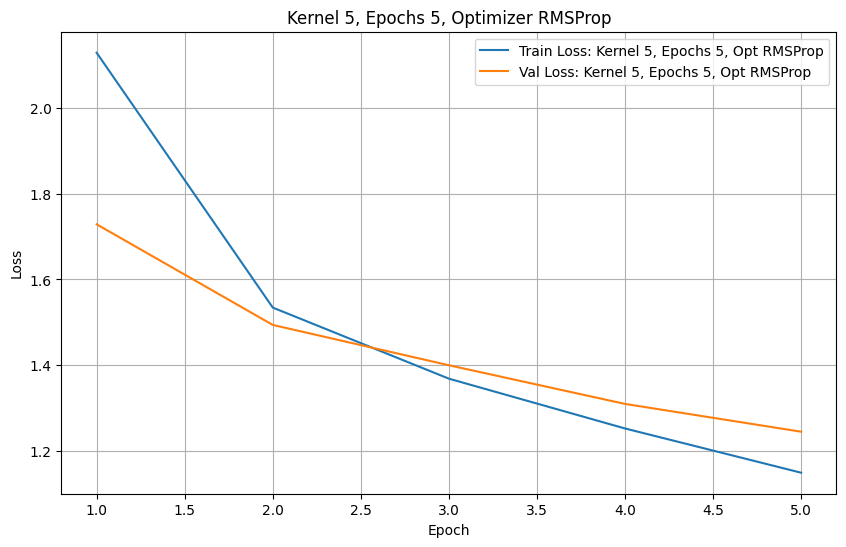

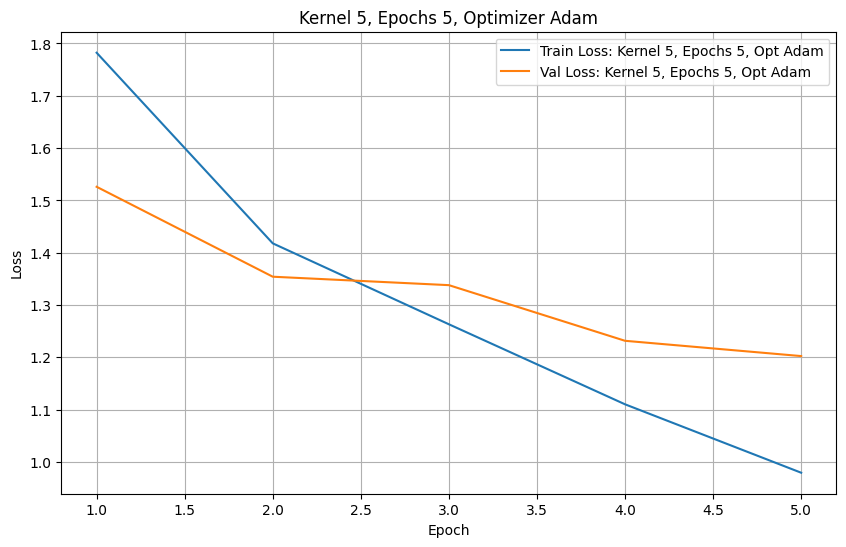

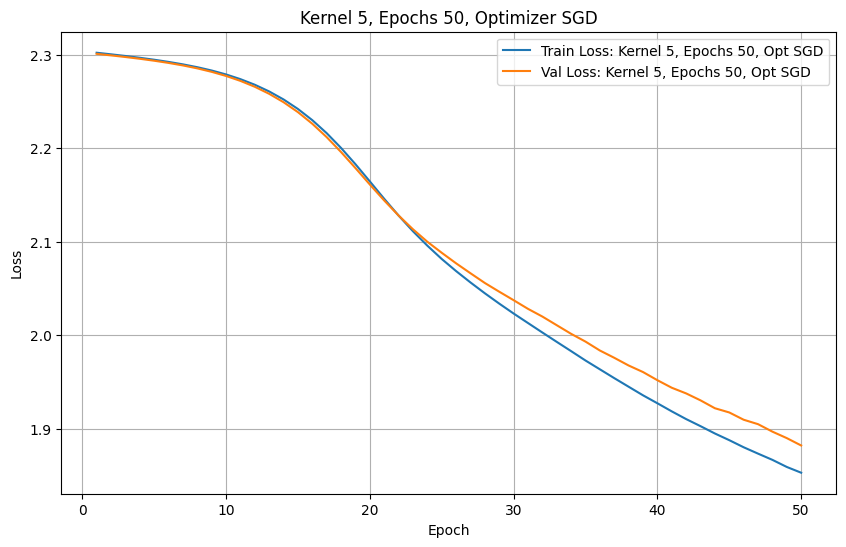

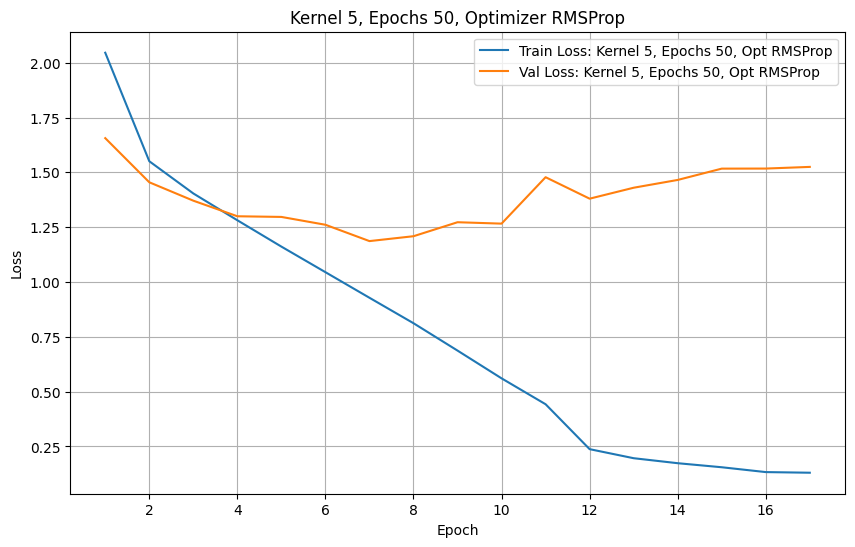

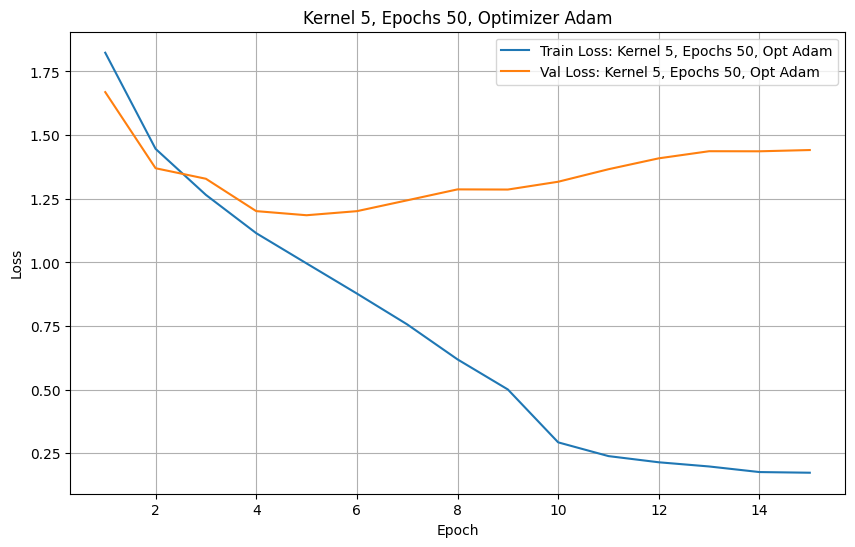

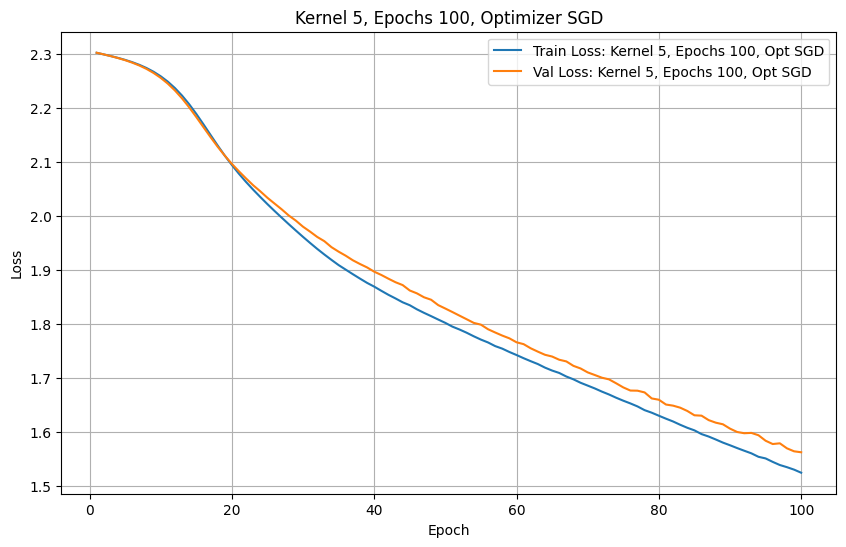

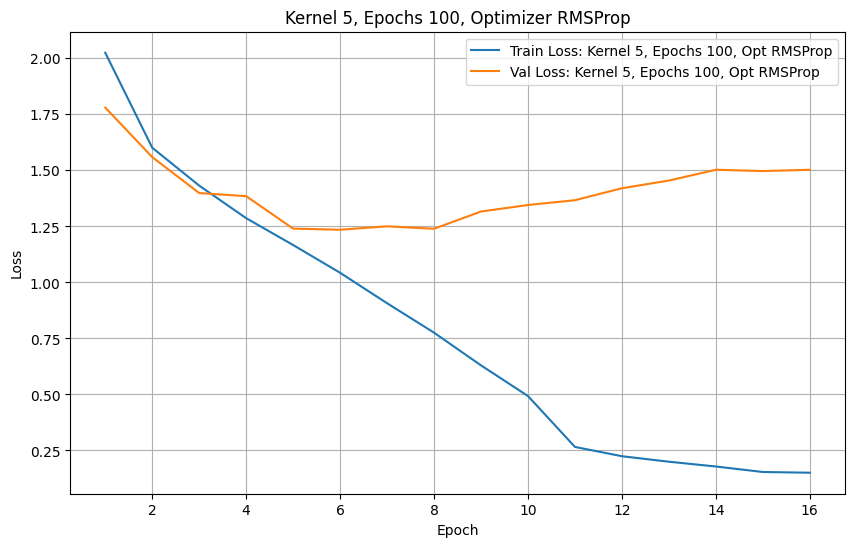

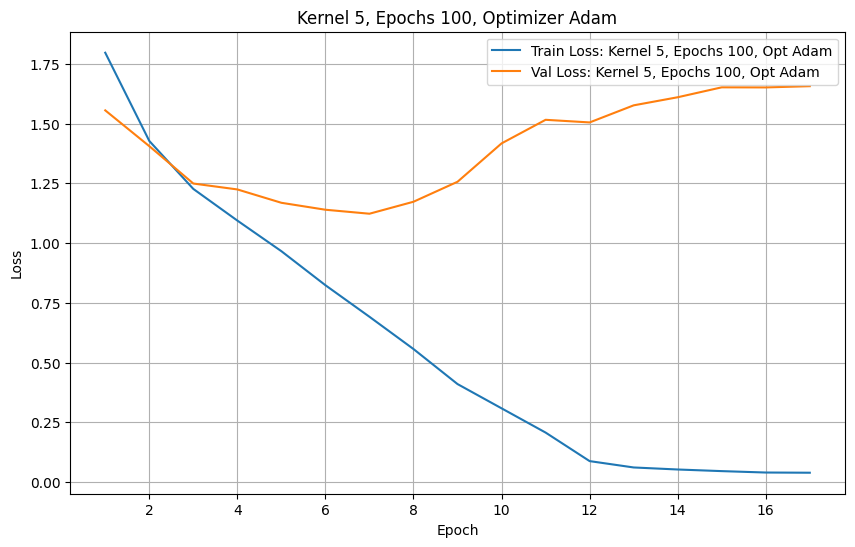

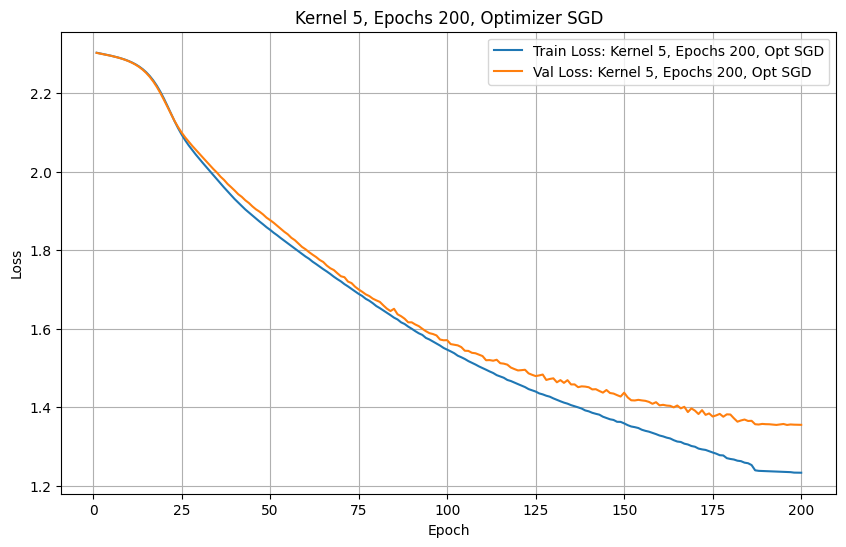

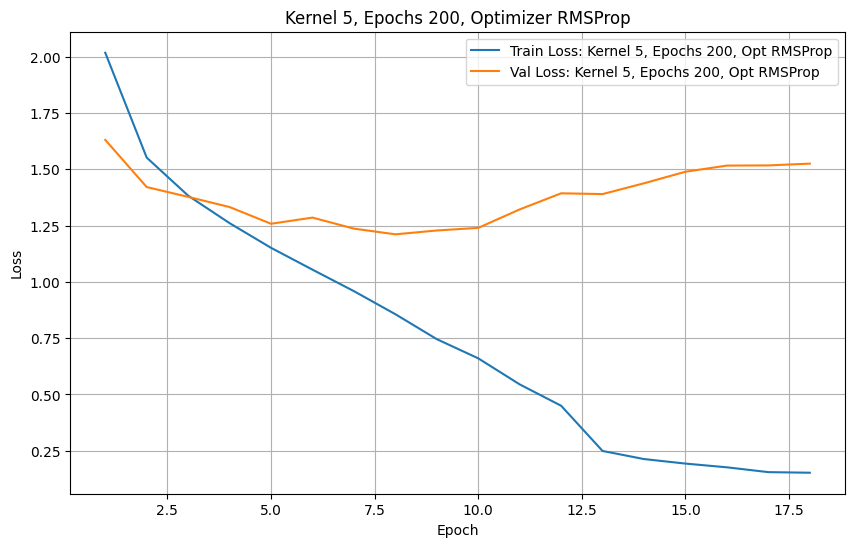

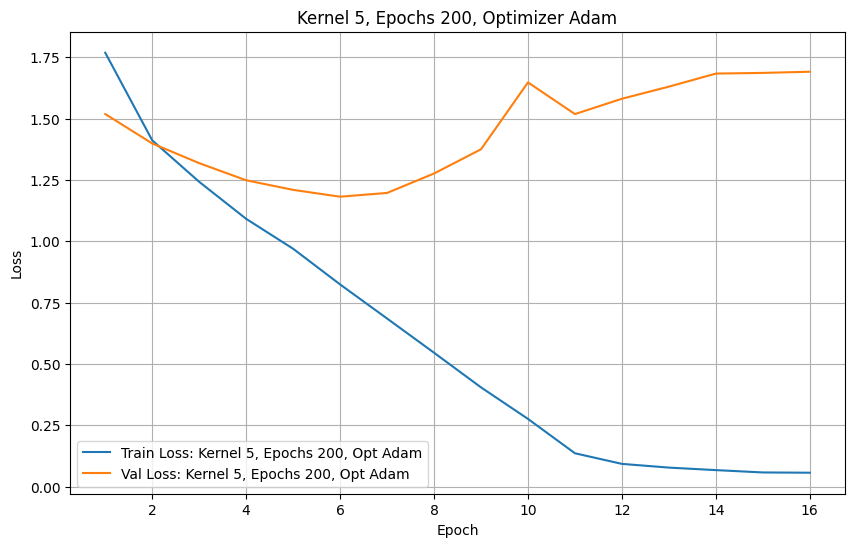

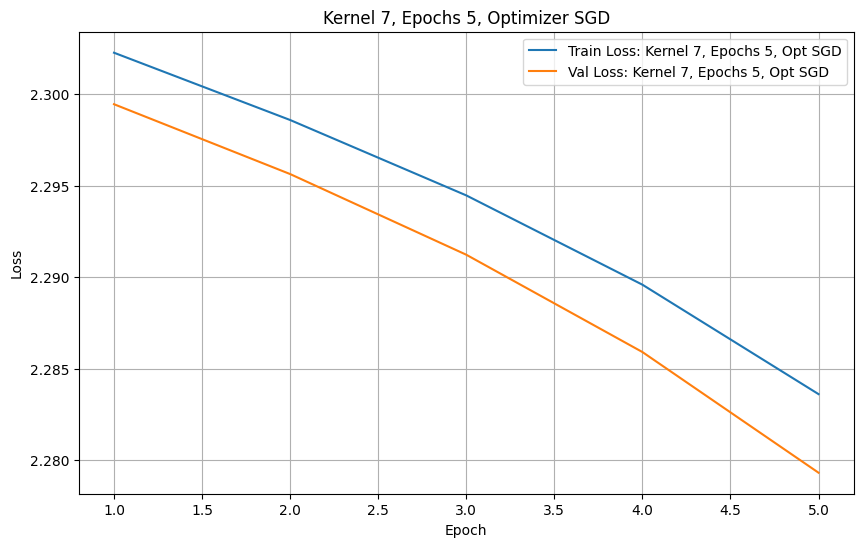

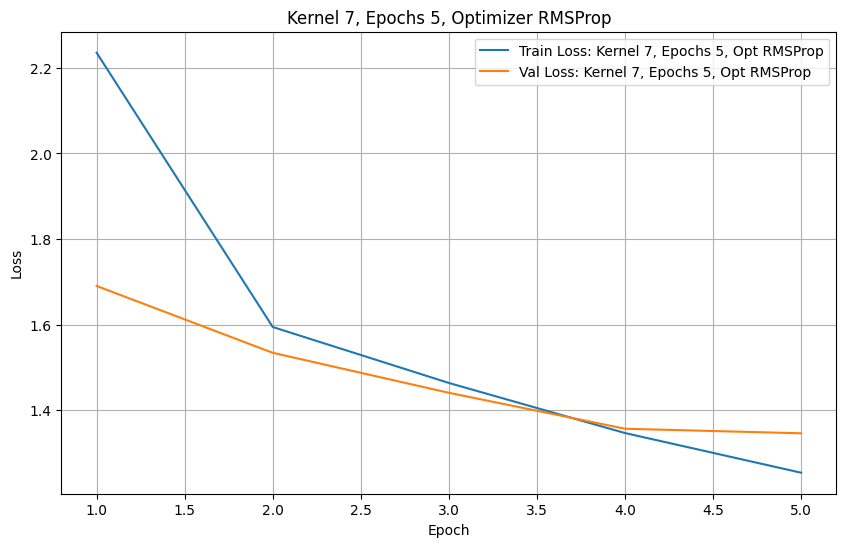

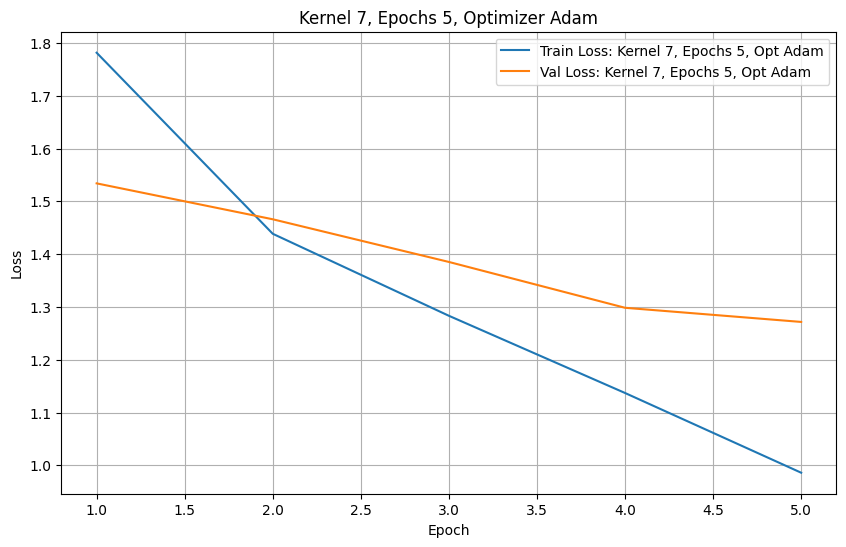

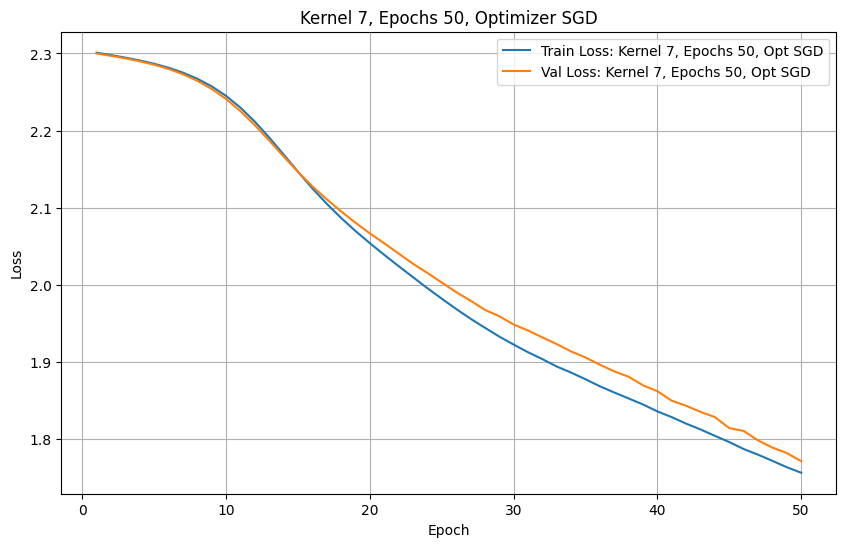

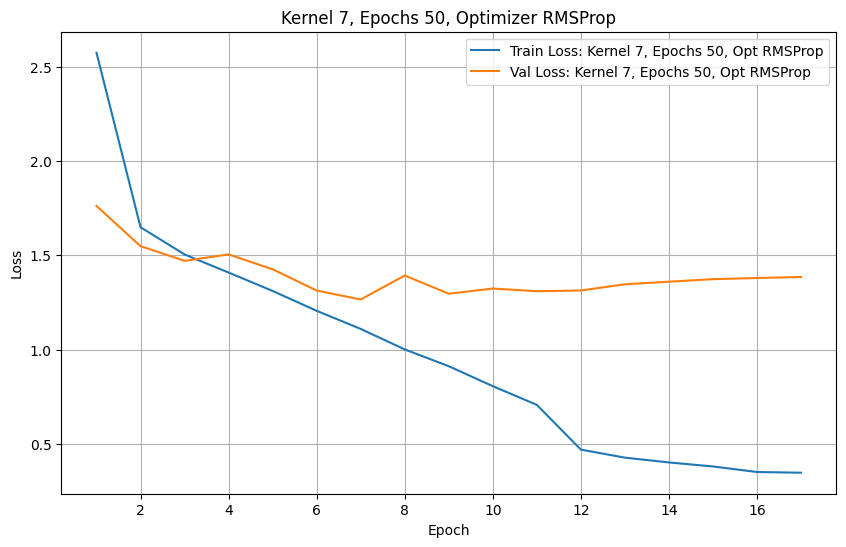

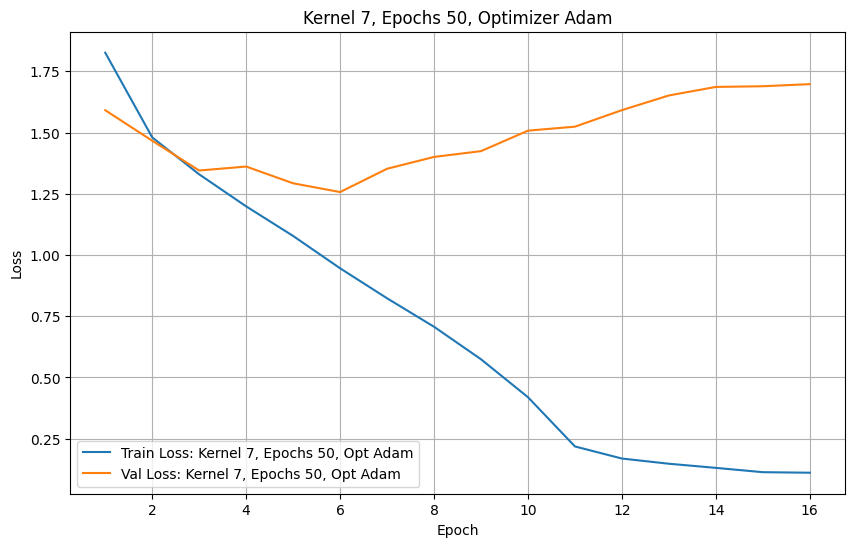

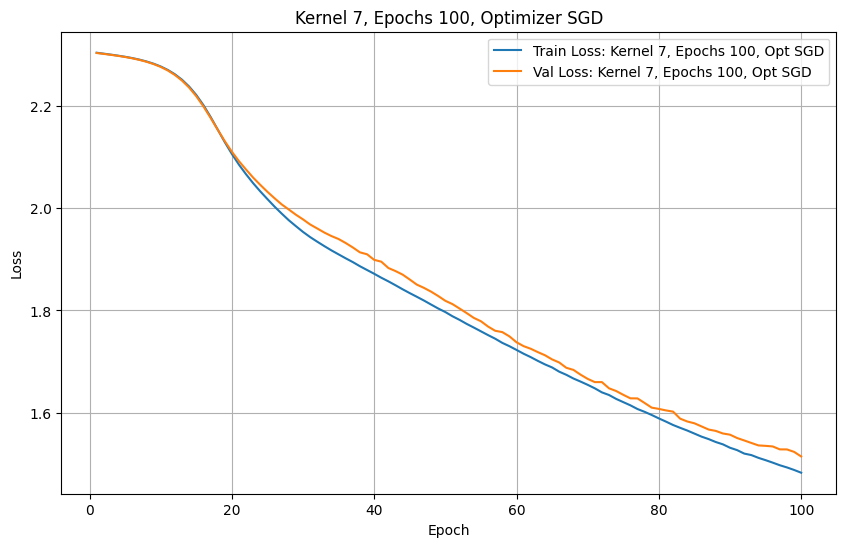

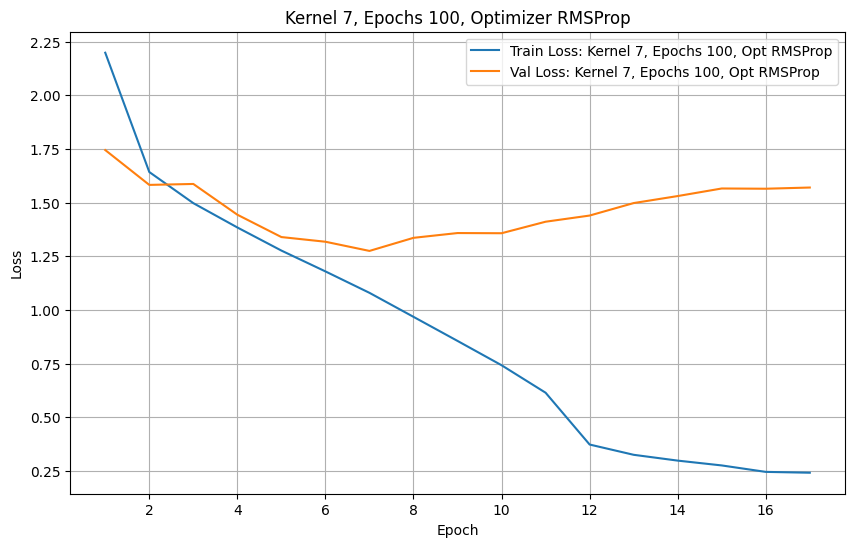

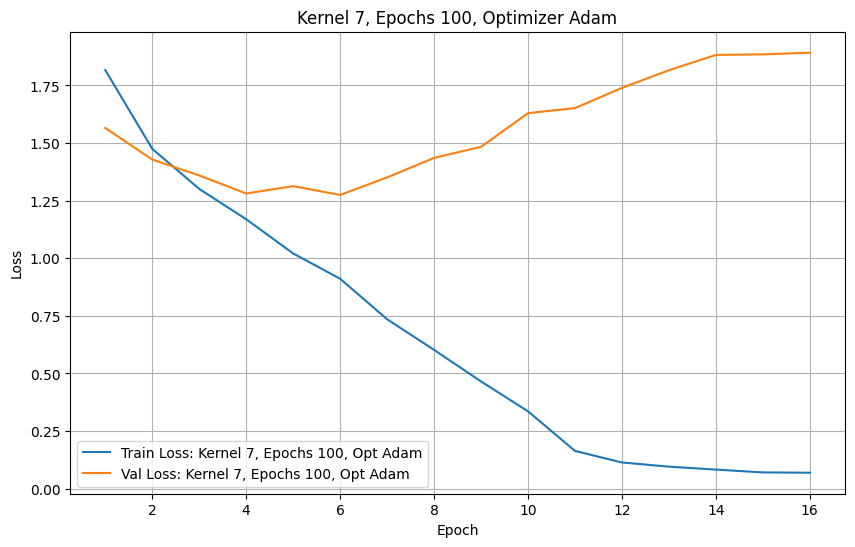

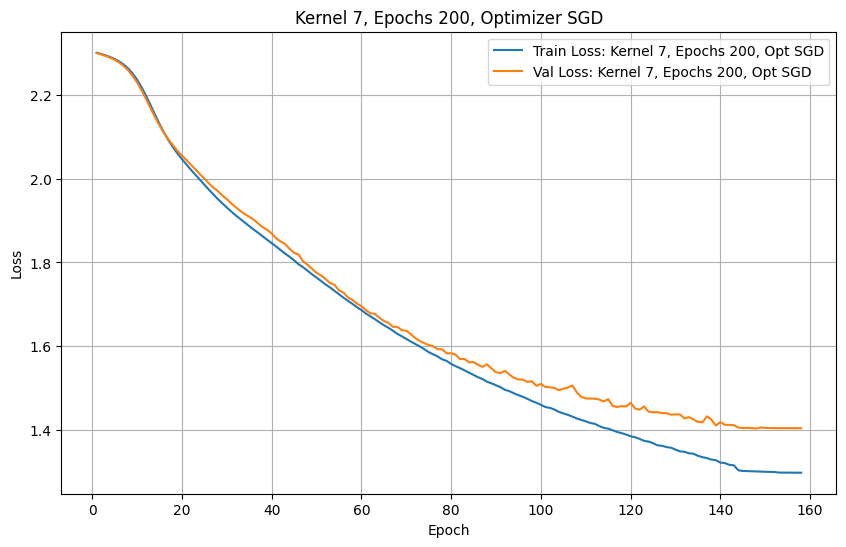

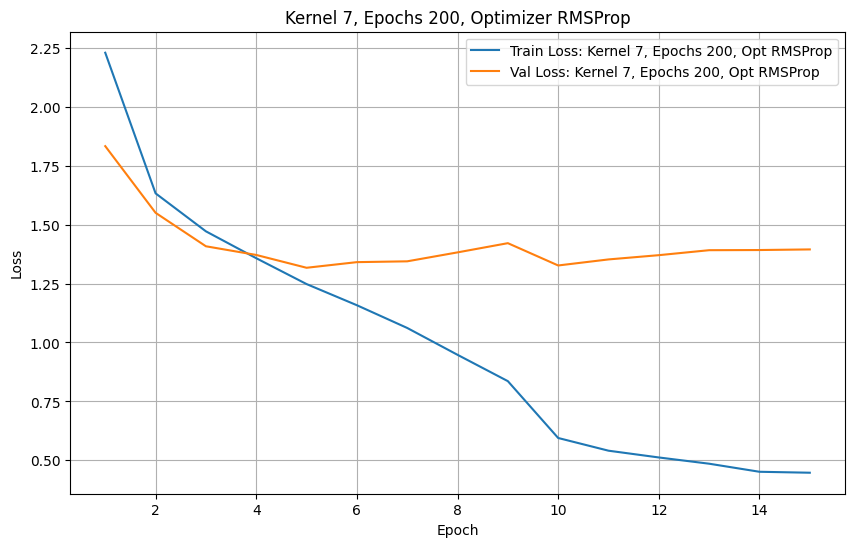

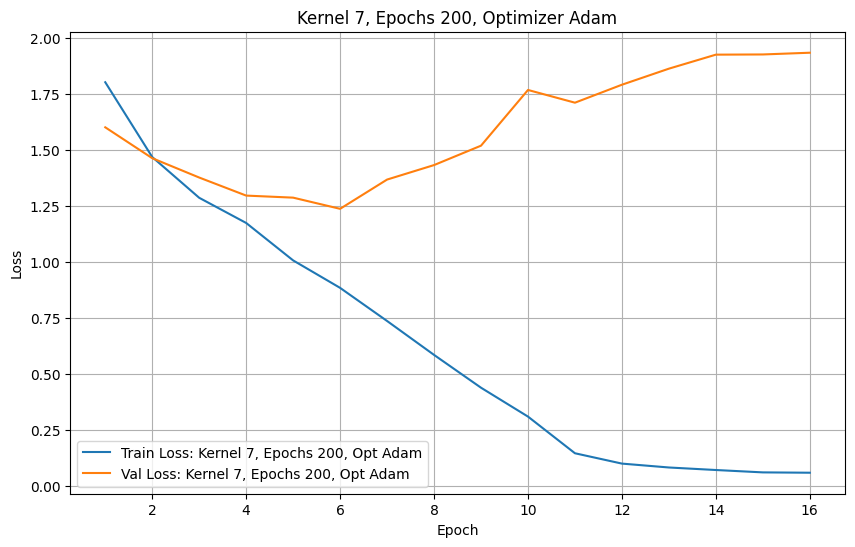

In [29]:
# Visualisasi hasil per konfigurasi
for key, (train_losses, val_losses) in results.items():
    kernel_size, epochs, opt_name = key
    epochs_range = range(1, len(train_losses)+1)
    plt.figure(figsize=(10, 6))
    plt.plot(epochs_range, train_losses, label=f"Train Loss: Kernel {kernel_size}, Epochs {epochs}, Opt {opt_name}")
    plt.plot(epochs_range, val_losses, label=f"Val Loss: Kernel {kernel_size}, Epochs {epochs}, Opt {opt_name}")
    plt.title(f"Kernel {kernel_size}, Epochs {epochs}, Optimizer {opt_name}")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True)
    plt.show()

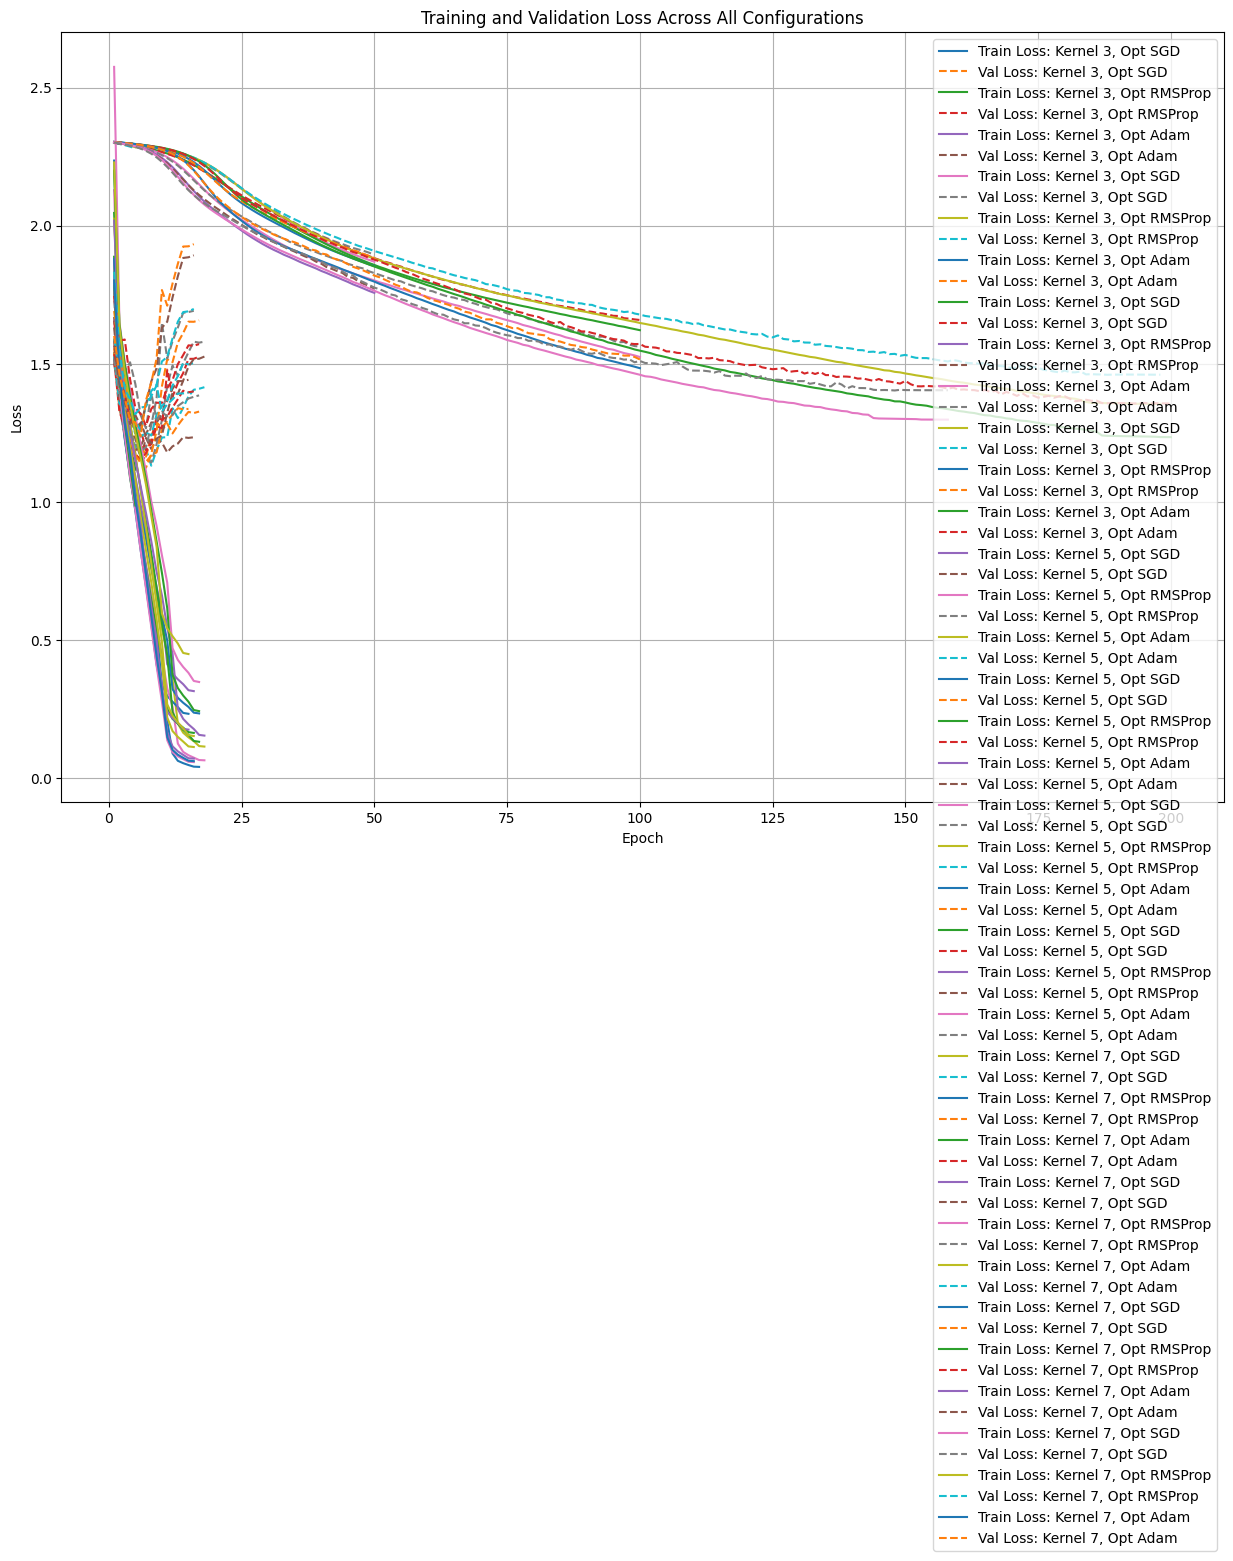

In [30]:
# Visualisasi gabungan semua konfigurasi
plt.figure(figsize=(15, 10))
for key, (train_losses, val_losses) in results.items():
    kernel_size, epochs, opt_name = key
    epochs_range = range(1, len(train_losses)+1)
    plt.plot(epochs_range, train_losses, label=f"Train Loss: Kernel {kernel_size}, Opt {opt_name}")
    plt.plot(epochs_range, val_losses, linestyle='dashed', label=f"Val Loss: Kernel {kernel_size}, Opt {opt_name}")

plt.title("Training and Validation Loss Across All Configurations")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()


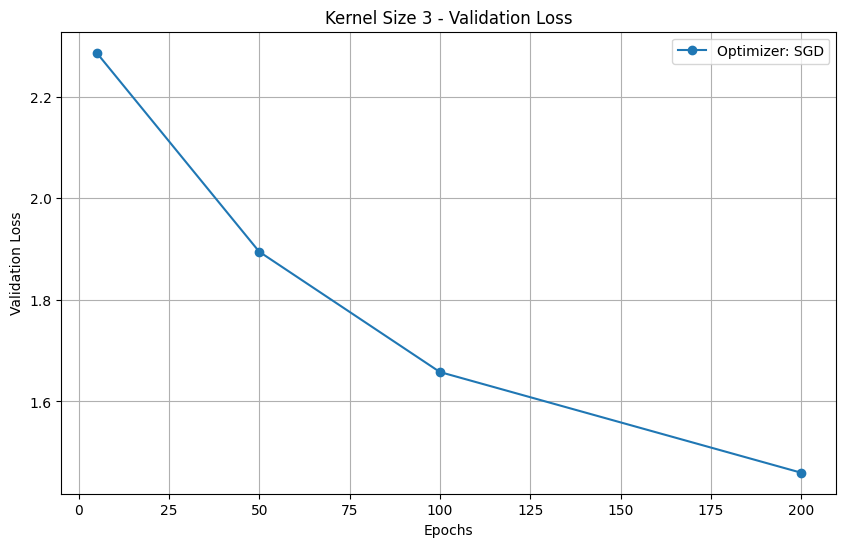

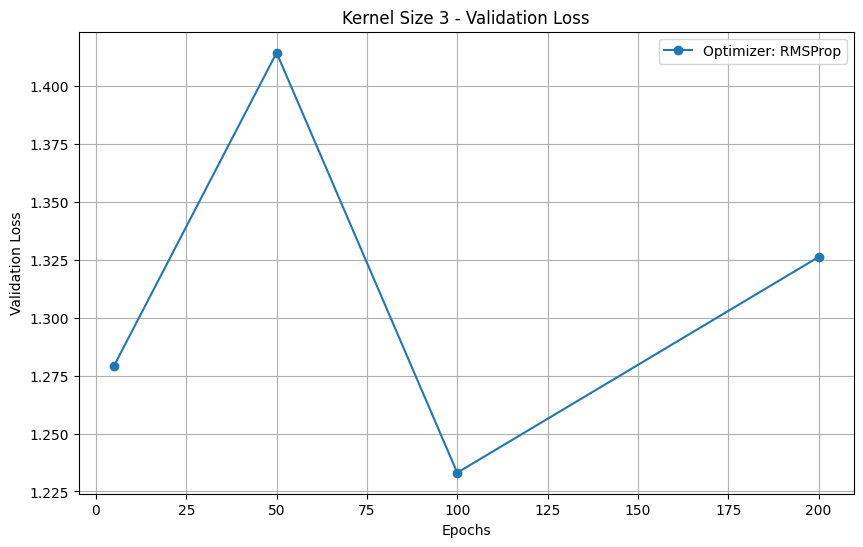

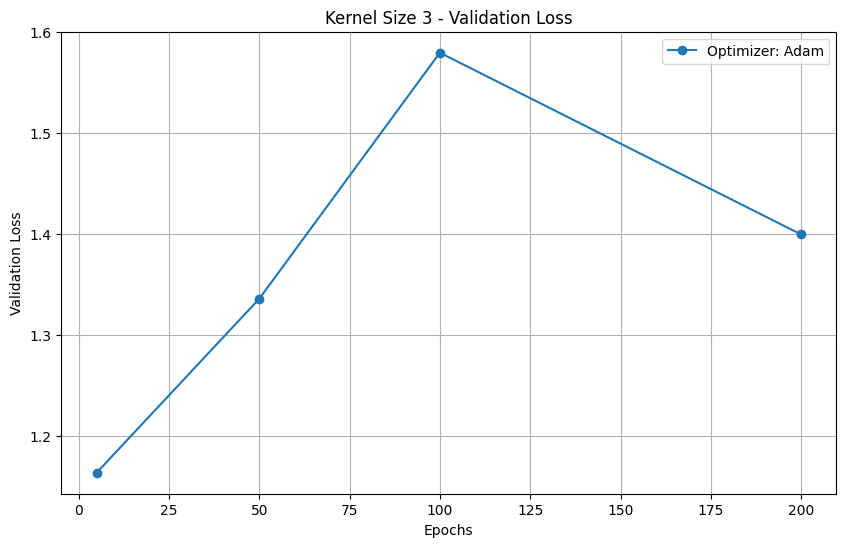

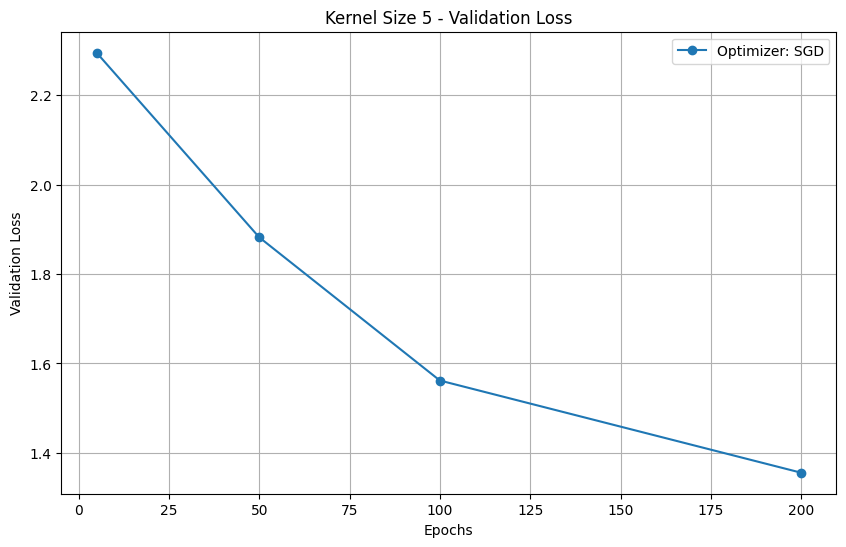

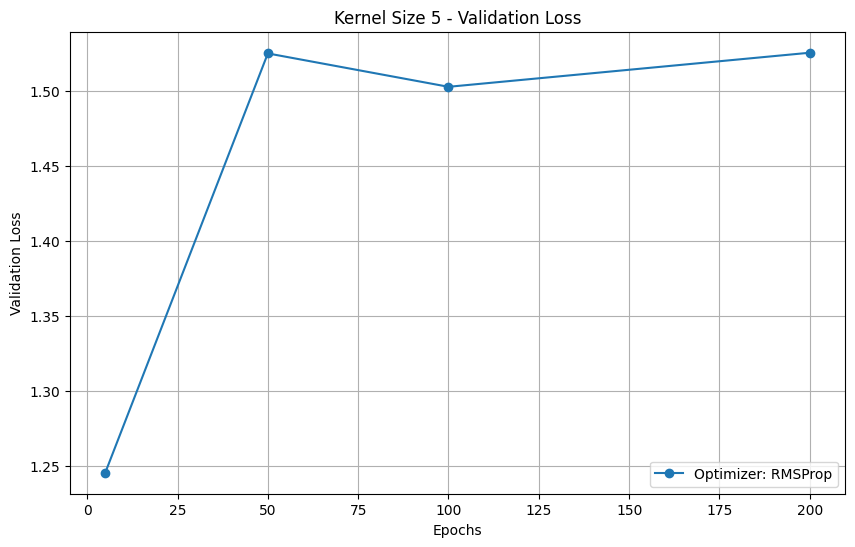

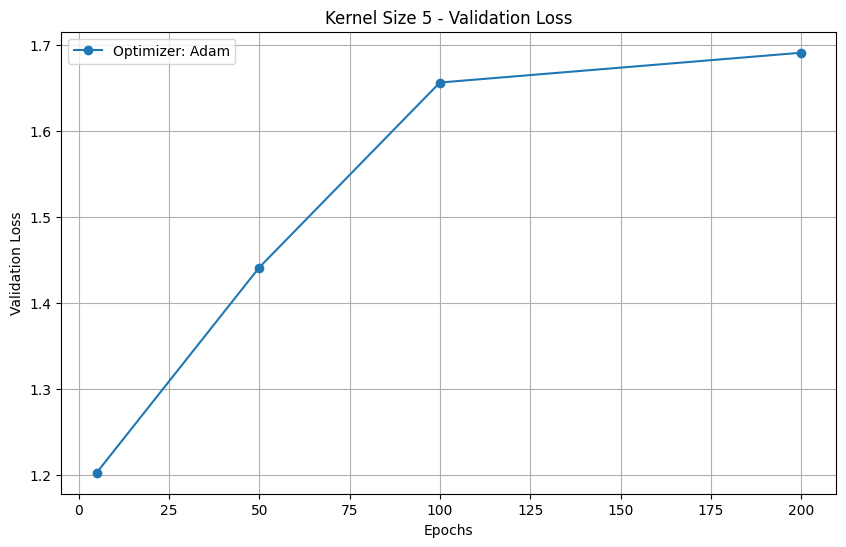

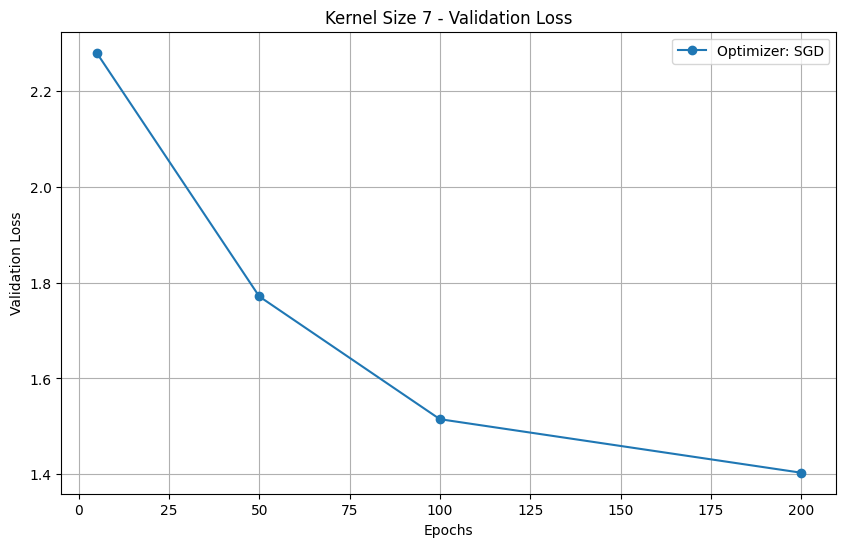

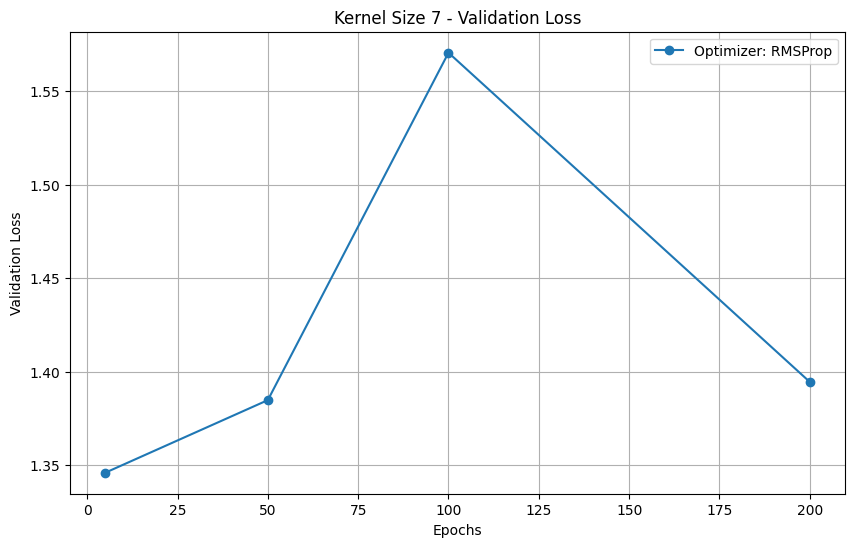

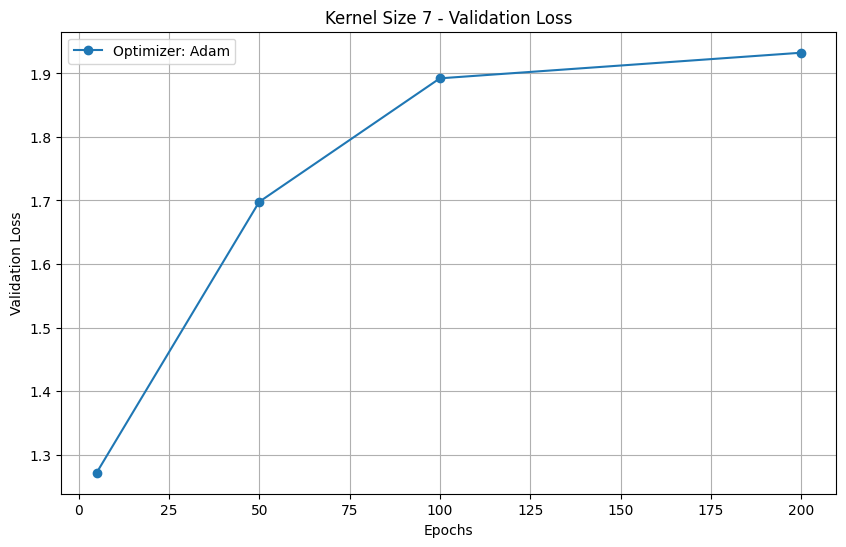

In [31]:
# Visualisasi hubungan kernel, epoch, dan optimizer
summary_data = {}
for (kernel_size, epochs, opt_name), (train_losses, val_losses) in results.items():
    final_val_loss = val_losses[-1] if val_losses else None
    if (kernel_size, opt_name) not in summary_data:
        summary_data[(kernel_size, opt_name)] = []
    summary_data[(kernel_size, opt_name)].append((epochs, final_val_loss))

# Plot hubungan kernel size, epoch, dan optimizer
for (kernel_size, opt_name), data in summary_data.items():
    data = sorted(data, key=lambda x: x[0])  # Urutkan berdasarkan epoch
    epochs = [item[0] for item in data]
    val_losses = [item[1] for item in data]
    plt.figure(figsize=(10, 6))
    plt.plot(epochs, val_losses, marker='o', label=f"Optimizer: {opt_name}")
    plt.title(f"Kernel Size {kernel_size} - Validation Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Validation Loss")
    plt.legend()
    plt.grid(True)
    plt.show()